In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
def get_skus(n):
    r_skus = np.arange(1, n+1,1)
    sku_perc = np.random.dirichlet(np.ones(len(r_skus))*1000.,size=1)
    return pd.DataFrame(list(zip(r_skus, sku_perc[0])), columns=['sku', 'sku_percent'])

In [4]:
# Let's make a few SKUs...somewhere above 20 sku, the sampling below will fail
df_skus = get_skus(20)
df_skus

,sku,sku_percent
0,1,0.049325
1,2,0.051330
2,3,0.050052
3,4,0.053228
4,5,0.050102
5,6,0.050681
6,7,0.046348
7,8,0.049796
8,9,0.049721
9,10,0.049027


In [5]:
n_samples, n_burn = 1000, 2000

# historically, we observe that this style is bought 15% of the time
style_percent_obs = 0.15

# we plan 1000 units of this style for next year
style_demand_planned = 1000

with pm.Model() as model:

    # we'll model the style distribution as a uniform prior
    style_percent = pm.Uniform('style_percent', 0, 1, testval=style_percent_obs)
    style_demand = pm.Deterministic('style_demand', style_demand_planned * style_percent)
    
    # then for every sku, we model the sku distribution as a uniform prior and
    # we want to determine the distribution of the resulting sku demand to be planned in units

    for _, sku in df_skus.iterrows():
        
        i = sku['sku']
        sku_perc = pm.Uniform(f'sku_percent_{i}', 0, 1, testval=sku['sku_percent'])
        sku_demand = pm.Deterministic(f'sku_demand_{i}', style_demand * sku_perc)

        sku_planned = pm.Poisson(f'sku_planned_{i}', mu=sku_demand, observed=np.ceil(style_demand_planned * sku['sku_percent']))

    trace = pm.sample(n_samples, tune=n_burn, random_seed=42, progressbar=True) 

KeyboardInterrupt: 

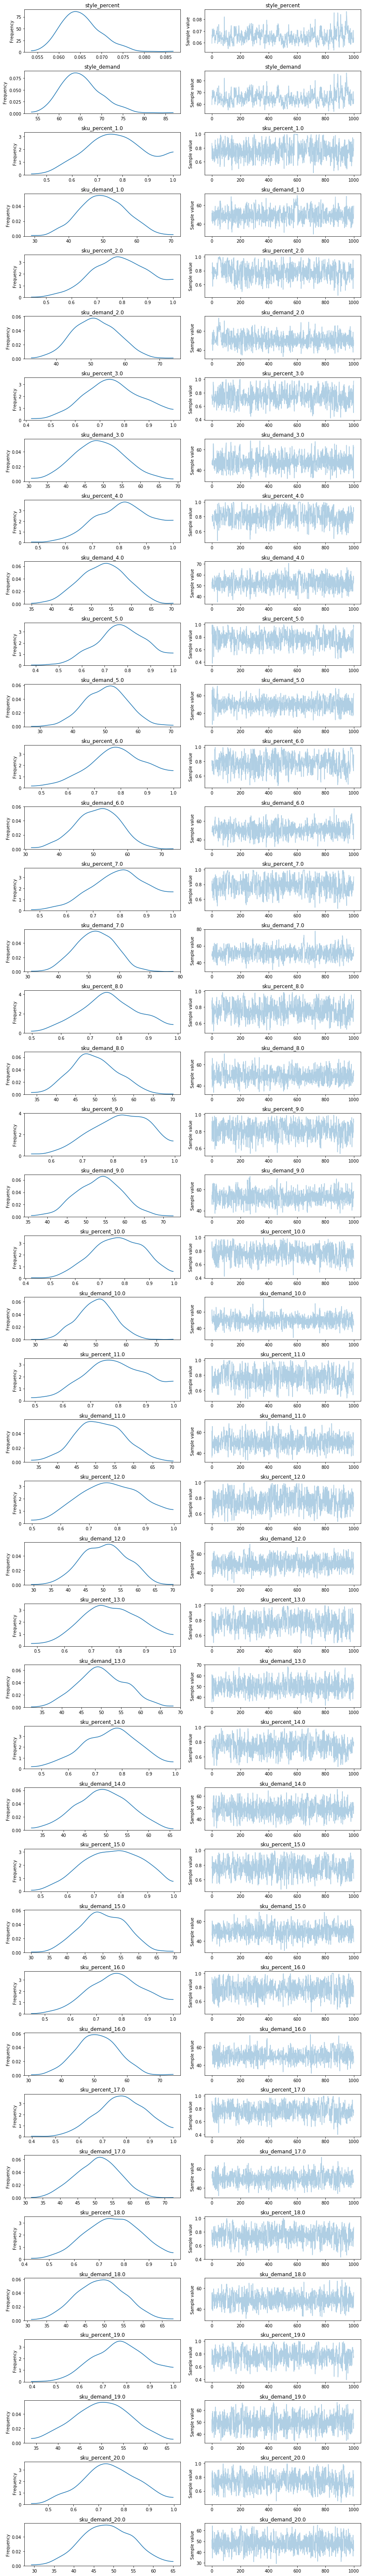

In [42]:
pm.traceplot(trace);